In [1]:
# PERCENT OF ARRESTS BY UNIT NUMBER
# ARRESTS BY OFFICER ID
# PERCENT OF RACE ARRESTS BY OFFICER
# ZIP CODES WITH HIGHEST NUMBER OF ARRESTS

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn import preprocessing, metrics, ensemble
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

In [3]:
df_clean = pd.read_csv('ISR_data_clean.csv',low_memory=False)
df_clean.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,HOTSPOT_NO,EVENT_NO,MISSION_NO,CPD_UNIT_NO,CREATED_BY,CREATED_DATE,MODIFIED_BY,MODIFIED_DATE,AGE,AGE_TO,SEX_CODE_CD,RACE_CODE_CD,HEIGHT,WEIGHT,BUILD_CODE_CD,EYE_COLOR_CODE_CD,HAIR_COLOR_CODE_CD,HAIR_STYLE_CODE_CD,COMPLEXION_CODE_CD,STREET_NO,STREET_DIRECTION_CD,STREET_NME,CITY,STATE_CD,ZIP_CD,DISTRICT,SECTOR,BEAT,AREA,RES_DISTRICT,RES_SECTOR,RES_BEAT,RES_AREA,BUS_DISTRICT,BUS_SECTOR,BUS_BEAT,BUS_AREA,SUBMITTING_UNIT,CONTACT_TYPE_DESCR,V_YEAR,MAKE_CD,MAKE_DESCR,STYLE_CD,STYLE_DESCR,MODEL_DESCR,COLOR_TOP,COLOR_BOTTOM,FO_EMPLOYEE_ID,SO_EMPLOYEE_ID,SUPV_EMPLOYEE_ID,GANG,KNOWN_HANGOUT,FACTION_NAME,CONTACT_CARD_STATUS_CD,LOCATION_CD,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,ENFORCEMENT_ACTION_TAKEN_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,FIREARM_I,COCAINE_I,COCAINE_AMOUNT,HEROIN_I,HEROIN_AMOUNT,OTHER_WEAPON_I,OTHER_WEAPON_DESCR,CANNABIS_I,CANNABIS_AMOUNT,OTHER_CON_SUB_I,OTHER_CON_SUB,OTHER_CON_SUB_AMT,SEARCH_I,SEARCH_CONSENT_I,SEARCH_CONTRABAND_FOUND_I,SEARCH_FIREARM_I,SEARCH_COCAINE_I,SEARCH_COCAINE_AMOUNT,SEARCH_HEROIN_I,SEARCH_HEROIN_AMOUNT,SEARCH_OTHER_WEAPON_I,SEARCH_OTHER_WEAPON_DESCR,SEARCH_CANNABIS_I,SEARCH_CANNABIS_AMOUNT,SEARCH_OTHER_CON_SUB_I,SEARCH_OTHER_CON_SUB_DESCR,SEARCH_OTHER_CON_SUB_AMT,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ENFORCEMENT_TYPE_CD,ENFORCEMENT_ID_NO,ALCOHOL_I,PARA_I,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,GANG_OTHER,OTHER_DESCR,S_OTHER_I,S_OTHER_DESCR,NAME
0,20410357,INVSTG,ISR000410357,01-JAN-2018 00:08,0,2523,N,"BROWN JACKET, JEANS",NaN,JB100012,NaN,121,NaN,25,185285,01-JAN-2018 01:46,185285.0,01-JAN-2018 01:47,30.0,NaN,M,WWH,506,165,MED,BRO,BLK,SHORT,MED,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,16.0,163.0,1634.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185285,845723.0,184324.0,UNKNOWN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,Y,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN
1,20410350,INVSTG,ISR000410350,01-JAN-2018 00:08,0,2523,N,BLUE JEANS AND A BLACK SWEATER,NaN,JB100012,NaN,121,NaN,25,675642,01-JAN-2018 01:35,675642.0,01-JAN-2018 01:38,20.0,NaN,M,WWH,510,175,MED,BRO,BLK,MED,LBR,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,25.0,252.0,2523.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675642,845723.0,184324.0,NaN,NaN,NaN,APP,289,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20410351,INVSTG,ISR000410351,01-JAN-2018 00:08,0,2523,N,"GRAY HOODED SWEATER, JEANS",NaN,JB100012,NaN,121,NaN,25,185285,01-JAN-2018 01:35,185285.0,01-JAN-2018 01:36,23.0,NaN,M,WWH,508,170,MED,BRO,BAL,SHORT,MED,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,25.0,253.0,2535.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185285,845723.0,184324.0,UNKNOWN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,Y,NaN,NaN,NaN,NaN,N

In [4]:
# PERCENT OF ARRESTS BY UNIT NUMBER
# get binary to represent arrest

arrest_count = df_clean[['ENFORCEMENT_TYPE_CD', 'SUBMITTING_UNIT', 'SUBMITTING_BEAT_CD', 'CREATED_BY', 'RACE_CODE_CD', 'FO_EMPLOYEE_ID', 'SO_EMPLOYEE_ID', 'SUPV_EMPLOYEE_ID']]

In [5]:
arrest_count['TARGET'] = np.where(arrest_count['ENFORCEMENT_TYPE_CD'] == 'ARR', 1, 0)
arrest_count.head(20)

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ENFORCEMENT_TYPE_CD,SUBMITTING_UNIT,SUBMITTING_BEAT_CD,CREATED_BY,RACE_CODE_CD,FO_EMPLOYEE_ID,SO_EMPLOYEE_ID,SUPV_EMPLOYEE_ID,TARGET
0,NaN,25,2523,185285,WWH,185285,845723.0,184324.0,0
1,NaN,25,2523,675642,WWH,675642,845723.0,184324.0,0
2,NaN,25,2523,185285,WWH,185285,845723.0,184324.0,0
3,NaN,313,6738,469481,WWH,469481,767063.0,225434.0,0
4,NaN,7,0767,666758,BLK,666758,816630.0,517843.0,0
5,NaN,7,0767,666758,BLK,666758,816630.0,517843.0,0
6,NaN,7,0767,666758,BLK,666758,816630.0,517843.0,0
7,NaN,7,0767,666758,BLK,666758,816630.0,517843.0,0
8,ARR,14,1461,555358,BLK,555358,614048.0,621961.0,1
9,ARR,14,1461,555358,BLK,555358,614048.0,621961.0,1


In [6]:
# remove lines missing SO_EMPLOYEE_ID
arrest_count.dropna(subset = ["SO_EMPLOYEE_ID"], axis=0, inplace=True)
arrest_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243702 entries, 0 to 290144
Data columns (total 9 columns):
ENFORCEMENT_TYPE_CD    54485 non-null object
SUBMITTING_UNIT        243702 non-null int64
SUBMITTING_BEAT_CD     243702 non-null object
CREATED_BY             243702 non-null int64
RACE_CODE_CD           243702 non-null object
FO_EMPLOYEE_ID         243702 non-null int64
SO_EMPLOYEE_ID         243702 non-null float64
SUPV_EMPLOYEE_ID       243628 non-null float64
TARGET                 243702 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 18.6+ MB


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
# remove lines missing SUPV_EMPLOYEE_ID
arrest_count.dropna(subset = ["SUPV_EMPLOYEE_ID"], axis=0, inplace=True)
arrest_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243628 entries, 0 to 290144
Data columns (total 9 columns):
ENFORCEMENT_TYPE_CD    54463 non-null object
SUBMITTING_UNIT        243628 non-null int64
SUBMITTING_BEAT_CD     243628 non-null object
CREATED_BY             243628 non-null int64
RACE_CODE_CD           243628 non-null object
FO_EMPLOYEE_ID         243628 non-null int64
SO_EMPLOYEE_ID         243628 non-null float64
SUPV_EMPLOYEE_ID       243628 non-null float64
TARGET                 243628 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 18.6+ MB


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
#  drop enforcement type, since it informs target

arrest_count.drop(columns = ["ENFORCEMENT_TYPE_CD"], axis=0, inplace=True)
arrest_count.info()

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 243628 entries, 0 to 290144
Data columns (total 8 columns):
SUBMITTING_UNIT       243628 non-null int64
SUBMITTING_BEAT_CD    243628 non-null object
CREATED_BY            243628 non-null int64
RACE_CODE_CD          243628 non-null object
FO_EMPLOYEE_ID        243628 non-null int64
SO_EMPLOYEE_ID        243628 non-null float64
SUPV_EMPLOYEE_ID      243628 non-null float64
TARGET                243628 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 16.7+ MB


In [9]:
# EDA before we move on to the model

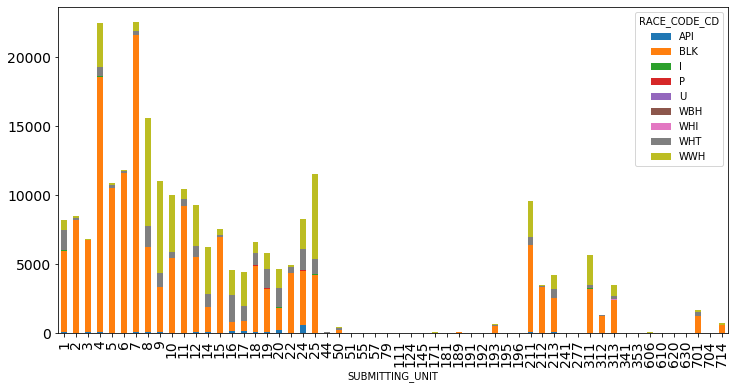

In [10]:
arrest_count.groupby(["SUBMITTING_UNIT","RACE_CODE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=14) 

In [11]:
# percentage of arrests - entire dataset

baseline_arrests = arrest_count[('TARGET')].value_counts(normalize=True) * 100
baseline_arrests

0    88.376952
1    11.623048
Name: TARGET, dtype: float64

In [12]:
first_emp_arrests = arrest_count.groupby('FO_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
first_emp_arrests.sort_values(by='TARGET', ascending=False).head(10)

# interesting - some officers have 100% arrest rates
# they might only have one or two rows in this dataset
# let's limit this to officers that have 20 or more rows

,FO_EMPLOYEE_ID,TARGET
5955,831547,1.0
4267,608301,1.0
4238,604621,1.0
5638,791046,1.0
1153,165553,1.0
1786,253251,1.0
5155,726578,1.0
282,38836,1.0
3199,461201,1.0
3201,461308,1.0


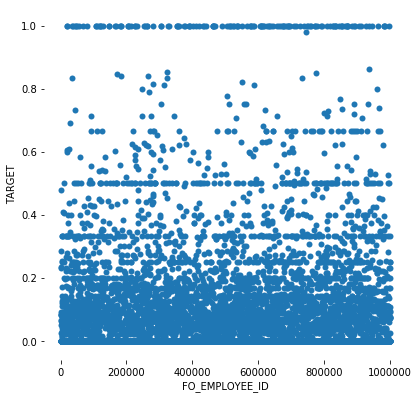

In [13]:
# scatterplot of employee arrest rates

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='FO_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=first_emp_arrests, ax=ax)

In [14]:
# exclude any officers that have 20 or fewer arrests

filtered = arrest_count.groupby('FO_EMPLOYEE_ID').filter(lambda x: len(x) >= 21)
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213478 entries, 0 to 290144
Data columns (total 8 columns):
SUBMITTING_UNIT       213478 non-null int64
SUBMITTING_BEAT_CD    213478 non-null object
CREATED_BY            213478 non-null int64
RACE_CODE_CD          213478 non-null object
FO_EMPLOYEE_ID        213478 non-null int64
SO_EMPLOYEE_ID        213478 non-null float64
SUPV_EMPLOYEE_ID      213478 non-null float64
TARGET                213478 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 14.7+ MB


In [15]:
filt_first_emp = filtered.groupby('FO_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
highest_50 = filt_first_emp.sort_values(by='TARGET', ascending=False)[:50]

In [16]:
highest_100 = filt_first_emp.sort_values(by='TARGET', ascending=False)[:100]

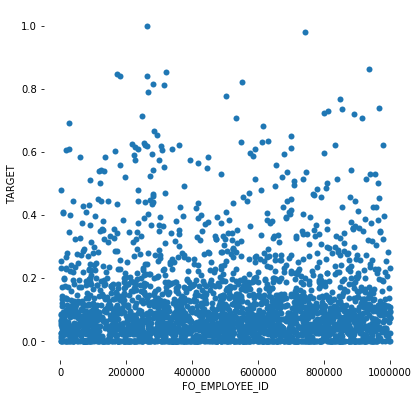

In [17]:
# here are all of the officers with more than 20 arrests

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='FO_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=filt_first_emp, ax=ax)



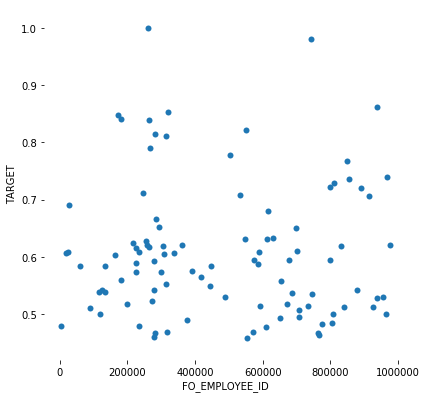

In [18]:
# highest_100 only

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='FO_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=highest_100, ax=ax)



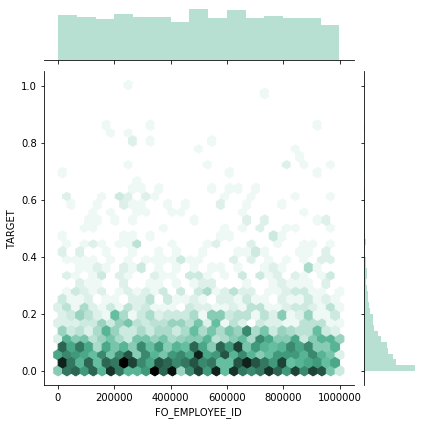

In [19]:
x = filt_first_emp['FO_EMPLOYEE_ID']
y = filt_first_emp['TARGET']

sns.jointplot(x, y, kind="hex", color="#4CB391")

In [20]:
# let's repeat the same thing, but with supervisors

In [21]:
arrest_count['SUPV_EMPLOYEE_ID'].nunique()

1239

In [22]:
supv_arrests = arrest_count.groupby('SUPV_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
supv_arrests.sort_values(by='TARGET', ascending=False).head(10)

,SUPV_EMPLOYEE_ID,TARGET
566,459073.0,1.0
766,616060.0,1.0
850,688690.0,1.0
274,212562.0,1.0
531,422310.0,1.0
873,703148.0,1.0
59,46235.0,1.0
667,532982.0,1.0
365,285934.0,1.0
815,651965.0,1.0


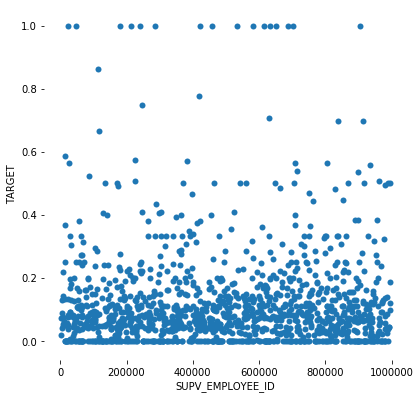

In [23]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='SUPV_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=supv_arrests, ax=ax)

In [24]:
filtered_supv = arrest_count.groupby('SUPV_EMPLOYEE_ID').filter(lambda x: len(x) >= 21)
filtered_supv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240822 entries, 0 to 290144
Data columns (total 8 columns):
SUBMITTING_UNIT       240822 non-null int64
SUBMITTING_BEAT_CD    240822 non-null object
CREATED_BY            240822 non-null int64
RACE_CODE_CD          240822 non-null object
FO_EMPLOYEE_ID        240822 non-null int64
SO_EMPLOYEE_ID        240822 non-null float64
SUPV_EMPLOYEE_ID      240822 non-null float64
TARGET                240822 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 16.5+ MB


In [25]:
filt_supv_arrests = filtered_supv.groupby('SUPV_EMPLOYEE_ID', as_index=False)['TARGET'].mean()
highest_50_supv = filt_supv_arrests.sort_values(by='TARGET', ascending=False).head(50)
highest_50_supv

,SUPV_EMPLOYEE_ID,TARGET
104,114341.0,0.860656
222,245635.0,0.748466
802,913839.0,0.698630
729,838875.0,0.697143
12,13429.0,0.587209
200,225434.0,0.574879
616,708954.0,0.565657
20,25330.0,0.565558
695,804918.0,0.563981
819,936333.0,0.557047


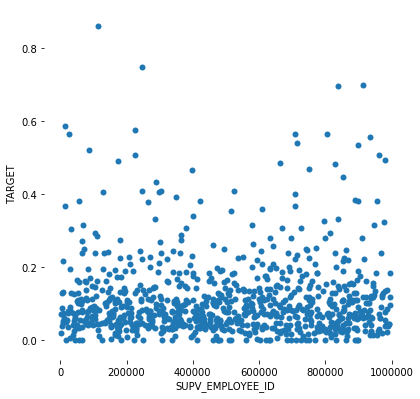

In [26]:
# here are all of the supervisors with more than 20 arrests

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='SUPV_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=filt_supv_arrests, ax=ax)

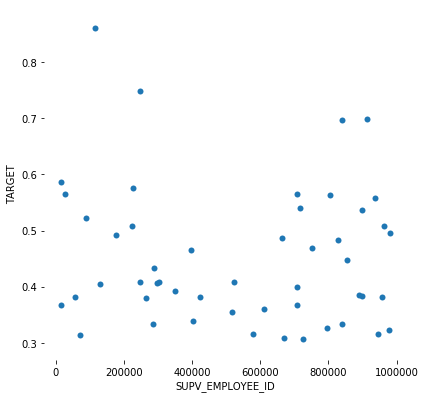

In [27]:
# highest_50_supv only

# here are all of the supervisors with more than 20 arrests

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='SUPV_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=highest_50_supv, ax=ax)

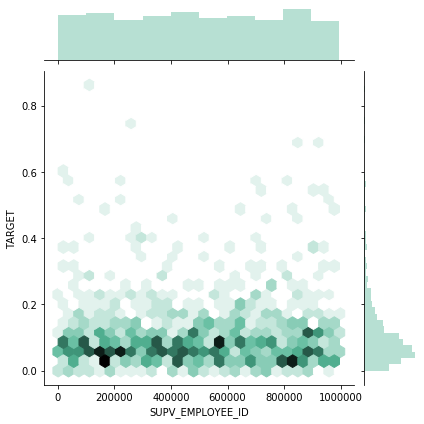

In [28]:
x = filt_supv_arrests['SUPV_EMPLOYEE_ID']
y = filt_supv_arrests['TARGET']

sns.jointplot(x, y, kind="hex", color="#4CB391")

In [29]:
# check to see if this changes with greater than 100 arrests

filtered_supv_100 = arrest_count.groupby('SUPV_EMPLOYEE_ID').filter(lambda x: len(x) >= 101)
filtered_supv_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224190 entries, 0 to 290144
Data columns (total 8 columns):
SUBMITTING_UNIT       224190 non-null int64
SUBMITTING_BEAT_CD    224190 non-null object
CREATED_BY            224190 non-null int64
RACE_CODE_CD          224190 non-null object
FO_EMPLOYEE_ID        224190 non-null int64
SO_EMPLOYEE_ID        224190 non-null float64
SUPV_EMPLOYEE_ID      224190 non-null float64
TARGET                224190 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 15.4+ MB


In [30]:
filt_supv_arrests_100 = filtered_supv_100.groupby('SUPV_EMPLOYEE_ID', as_index=False)['TARGET'].mean()

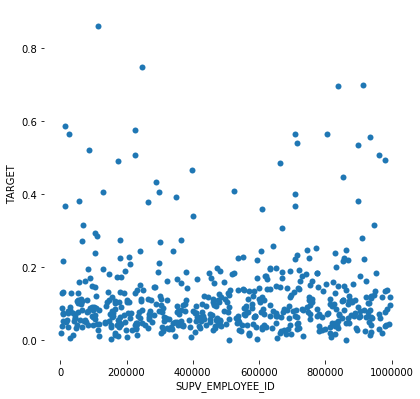

In [31]:
# here are the supervisors with more than 100 arrests

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='SUPV_EMPLOYEE_ID', y='TARGET',
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=filt_supv_arrests_100, ax=ax)

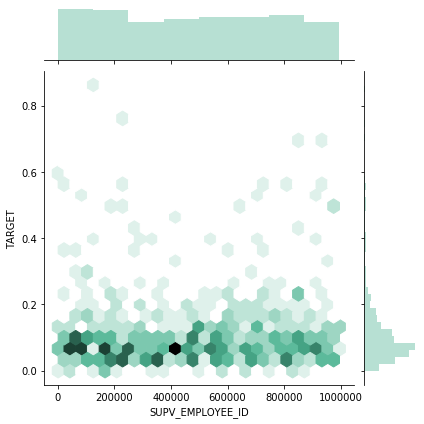

In [32]:
x = filt_supv_arrests_100['SUPV_EMPLOYEE_ID']
y = filt_supv_arrests_100['TARGET']

sns.jointplot(x, y, kind="hex", color="#4CB391")

In [33]:
# one last chart - count of arrests vs. mean target

In [34]:
# list out 50 worst officers
# target is "worst" list
# based on non-admin info, can we determine whether or not an arrest is from one of those 20?

In [35]:
# reset our index

highest_100.reset_index(drop=True, inplace=True)
highest_100.head()

,FO_EMPLOYEE_ID,TARGET
0,262036,1.000000
1,742961,0.980769
2,936724,0.861111
3,321618,0.852459
4,172179,0.847458


In [36]:
officer_id_list = highest_100['FO_EMPLOYEE_ID'].tolist()
officer_id_list

[262036,
 742961,
 936724,
 321618,
 172179,
 182526,
 264134,
 550037,
 280368,
 315172,
 266758,
 503311,
 848820,
 966601,
 854212,
 810090,
 800075,
 890525,
 246726,
 533328,
 913089,
 27357,
 614407,
 284218,
 292548,
 697816,
 630682,
 547176,
 611367,
 253928,
 216973,
 977291,
 360506,
 257912,
 831325,
 306571,
 264102,
 225187,
 700431,
 234679,
 590225,
 25384,
 337304,
 18303,
 309747,
 164957,
 800251,
 575508,
 678739,
 279273,
 224513,
 585016,
 448605,
 135158,
 58963,
 392445,
 226688,
 300586,
 417478,
 181539,
 653750,
 315721,
 445579,
 880097,
 124570,
 280244,
 117151,
 134083,
 687086,
 744489,
 955019,
 487230,
 938501,
 271480,
 672678,
 197782,
 591567,
 734747,
 839480,
 926695,
 90845,
 706906,
 119602,
 808481,
 963664,
 707649,
 651814,
 375781,
 806260,
 776800,
 2571,
 235297,
 609127,
 570985,
 316822,
 764897,
 281081,
 767927,
 279839,
 553722]

In [37]:
df_arrests = df_clean.copy()

In [38]:
# create binary column for officer id (this will be the target)

df_arrests['HIGHEST_100_OFFICERS'] = np.isin(df_arrests['FO_EMPLOYEE_ID'], officer_id_list)
df_arrests.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,HOTSPOT_NO,EVENT_NO,MISSION_NO,CPD_UNIT_NO,CREATED_BY,CREATED_DATE,MODIFIED_BY,MODIFIED_DATE,AGE,AGE_TO,SEX_CODE_CD,RACE_CODE_CD,HEIGHT,WEIGHT,BUILD_CODE_CD,EYE_COLOR_CODE_CD,HAIR_COLOR_CODE_CD,HAIR_STYLE_CODE_CD,COMPLEXION_CODE_CD,STREET_NO,STREET_DIRECTION_CD,STREET_NME,CITY,STATE_CD,ZIP_CD,DISTRICT,SECTOR,BEAT,AREA,RES_DISTRICT,RES_SECTOR,RES_BEAT,RES_AREA,BUS_DISTRICT,BUS_SECTOR,BUS_BEAT,BUS_AREA,SUBMITTING_UNIT,CONTACT_TYPE_DESCR,V_YEAR,MAKE_CD,MAKE_DESCR,STYLE_CD,STYLE_DESCR,MODEL_DESCR,COLOR_TOP,COLOR_BOTTOM,FO_EMPLOYEE_ID,SO_EMPLOYEE_ID,SUPV_EMPLOYEE_ID,GANG,KNOWN_HANGOUT,FACTION_NAME,CONTACT_CARD_STATUS_CD,LOCATION_CD,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,ENFORCEMENT_ACTION_TAKEN_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,FIREARM_I,COCAINE_I,COCAINE_AMOUNT,HEROIN_I,HEROIN_AMOUNT,OTHER_WEAPON_I,OTHER_WEAPON_DESCR,CANNABIS_I,CANNABIS_AMOUNT,OTHER_CON_SUB_I,OTHER_CON_SUB,OTHER_CON_SUB_AMT,SEARCH_I,SEARCH_CONSENT_I,SEARCH_CONTRABAND_FOUND_I,SEARCH_FIREARM_I,SEARCH_COCAINE_I,SEARCH_COCAINE_AMOUNT,SEARCH_HEROIN_I,SEARCH_HEROIN_AMOUNT,SEARCH_OTHER_WEAPON_I,SEARCH_OTHER_WEAPON_DESCR,SEARCH_CANNABIS_I,SEARCH_CANNABIS_AMOUNT,SEARCH_OTHER_CON_SUB_I,SEARCH_OTHER_CON_SUB_DESCR,SEARCH_OTHER_CON_SUB_AMT,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ENFORCEMENT_TYPE_CD,ENFORCEMENT_ID_NO,ALCOHOL_I,PARA_I,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,GANG_OTHER,OTHER_DESCR,S_OTHER_I,S_OTHER_DESCR,NAME,HIGHEST_100_OFFICERS
0,20410357,INVSTG,ISR000410357,01-JAN-2018 00:08,0,2523,N,"BROWN JACKET, JEANS",NaN,JB100012,NaN,121,NaN,25,185285,01-JAN-2018 01:46,185285.0,01-JAN-2018 01:47,30.0,NaN,M,WWH,506,165,MED,BRO,BLK,SHORT,MED,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,16.0,163.0,1634.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185285,845723.0,184324.0,UNKNOWN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,Y,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,False
1,20410350,INVSTG,ISR000410350,01-JAN-2018 00:08,0,2523,N,BLUE JEANS AND A BLACK SWEATER,NaN,JB100012,NaN,121,NaN,25,675642,01-JAN-2018 01:35,675642.0,01-JAN-2018 01:38,20.0,NaN,M,WWH,510,175,MED,BRO,BLK,MED,LBR,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,25.0,252.0,2523.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,675642,845723.0,184324.0,NaN,NaN,NaN,APP,289,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OEMC,Y,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,20410351,INVSTG,ISR000410351,01-JAN-2018 00:08,0,2523,N,"GRAY HOODED SWEATER, JEANS",NaN,JB100012,NaN,121,NaN,25,185285,01-JAN-2018 01:35,185285.0,01-JAN-2018 01:36,23.0,NaN,M,WWH,508,170,MED,BRO,BAL,SHORT,MED,40XX,W,OAKDALE AVE,CHICAGO,IL,60641,25,252,2523,3,25.0,253.0,2535.0,3,NaN,NaN,NaN,0,25,Investigatory Stop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185285,845723.0,184324.0,UNKNOWN,NaN,NaN,APP,303,N,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,Y,NaN,NaN,NaN,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [39]:
df_arrests['HIGHEST_100_OFFICERS'].value_counts()

False    281014
True       9131
Name: HIGHEST_100_OFFICERS, dtype: int64

In [40]:
# can we build a model that predicts if the arrest was made by one of the 20 "worst" officers?

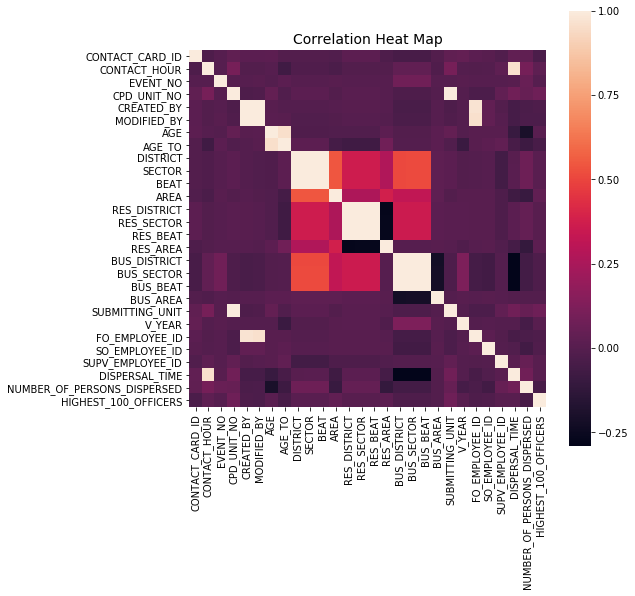

In [41]:
# correlation chart

corrmat = df_arrests.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

In [42]:
# remove columns with unit and beat identifying info, supervisor info, created by and modified by, etc.

df_arrests.drop(columns = ["CPD_UNIT_NO", "CREATED_BY", "MODIFIED_BY", "DISTRICT", "SECTOR", "BEAT", "RES_DISTRICT", "RES_SECTOR", "RES_BEAT"], axis=0, inplace=True)

In [43]:
# remove "duplicate" info - eg dispersal time and contact hour
df_arrests.drop(columns = ["DISPERSAL_TIME", "AGE_TO"], axis=0, inplace=True)

In [44]:
# still removing

df_arrests.drop(columns = ["SUBMITTING_UNIT", "FO_EMPLOYEE_ID", "SO_EMPLOYEE_ID", "SUPV_EMPLOYEE_ID"], axis=0, inplace=True)

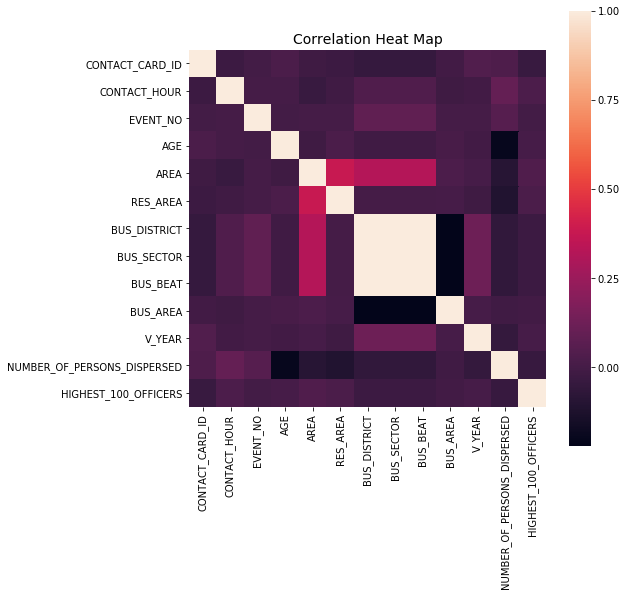

In [45]:
# correlation chart

corrmat = df_arrests.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

In [46]:
# also remove: CARD_NO, SUBMITTING_BEAT_CD, RD_NO, MODIFIED_DATE, STREET_NO, STREET_DIRECTION_CD, STREET_NME, CITY, STATE_CD, RES_AREA 

df_arrests.drop(columns = ["CARD_NO", "SUBMITTING_BEAT_CD", "RD_NO", "MODIFIED_DATE", "STREET_NO", "STREET_DIRECTION_CD", "STREET_NME", "CITY", "STATE_CD", "RES_AREA"], axis=0, inplace=True)

In [47]:
df_arrests.drop(columns = ["CLOTHING_DESCR", "EVENT_NO", "BUS_DISTRICT", "BUS_SECTOR", "BUS_BEAT", "BUS_AREA", "CONTACT_TYPE_DESCR"], axis=0, inplace=True)

In [48]:
df_arrests.drop(columns = ["CONTACT_CARD_ID", "CONTACT_DATE", "CONTACT_CARD_STATUS_CD", "LOCATION_CD"], axis=0, inplace=True)

In [49]:
df_arrests.drop(columns = ["V_YEAR", "MAKE_CD", "MAKE_DESCR", "STYLE_CD", "STYLE_DESCR", "MODEL_DESCR", "COLOR_TOP", "COLOR_BOTTOM"], axis=0, inplace=True)

In [50]:
df_arrests.drop(columns = ["FIREARM_I", "COCAINE_I", "COCAINE_AMOUNT", "HEROIN_I", "HEROIN_AMOUNT", "OTHER_WEAPON_I", "OTHER_WEAPON_DESCR", "CANNABIS_I", "CANNABIS_AMOUNT", "OTHER_CON_SUB_I", "OTHER_CON_SUB", "OTHER_CON_SUB_AMT"], axis=0, inplace=True)

In [51]:
df_arrests.drop(columns = ["SEARCH_CONTRABAND_FOUND_I","SEARCH_FIREARM_I", "SEARCH_COCAINE_I", "SEARCH_COCAINE_AMOUNT", "SEARCH_HEROIN_I", "SEARCH_HEROIN_AMOUNT", "SEARCH_OTHER_WEAPON_I", "SEARCH_OTHER_WEAPON_DESCR"], axis=0, inplace=True)

In [52]:
df_arrests.drop(columns = ["S_OTHER_DESCR", "S_OTHER_I", "OTHER_DESCR", "GANG_OTHER", "S_STOLEN_PROPERTY_I", "S_PARA_I", "S_ALCOHOL_I", "SEARCH_PROPERTY_I"], axis=0, inplace=True)

In [53]:
df_arrests.drop(columns = ["STOLEN_PROPERTY_I", "PARA_I", "SEARCH_OTHER_CON_SUB_DESCR", "SEARCH_OTHER_CON_SUB_AMT", "ENFORCEMENT_ID_NO"], axis=0, inplace=True)

In [54]:
df_arrests.drop(columns = ["SEARCH_CANNABIS_AMOUNT", "HOTSPOT_NO", "MISSION_NO"], axis=0, inplace=True)

In [55]:
df_arrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290145 entries, 0 to 290144
Data columns (total 57 columns):
CONTACT_TYPE_CD                  290145 non-null object
CONTACT_HOUR                     290145 non-null int64
JUVENILE_I                       290145 non-null object
NAME_VERIFIED_I                  126758 non-null object
CREATED_DATE                     290145 non-null object
AGE                              289342 non-null float64
SEX_CODE_CD                      290145 non-null object
RACE_CODE_CD                     290145 non-null object
HEIGHT                           290145 non-null object
WEIGHT                           290145 non-null object
BUILD_CODE_CD                    290145 non-null object
EYE_COLOR_CODE_CD                290145 non-null object
HAIR_COLOR_CODE_CD               290145 non-null object
HAIR_STYLE_CODE_CD               290145 non-null object
COMPLEXION_CODE_CD               290145 non-null object
ZIP_CD                           289734 non-null 

In [56]:
# change target true/false to binary

df_arrests['HIGHEST_100_OFFICERS'] = np.where(df_arrests['HIGHEST_100_OFFICERS'] == True, 1, 0)

In [57]:
label_encoder_contact_type = LabelEncoder()
label_encoder_contact_type = label_encoder_contact_type.fit(y)
label_encoded_y = label_encoder_contact_type.transform(y)

In [58]:
df_arrests['CONTACT_TYPE_CD'] = label_encoder_contact_type.fit_transform(df_arrests['CONTACT_TYPE_CD'])

In [59]:
label_encoder_juvenile = LabelEncoder()
label_encoder_juvenile = label_encoder_juvenile.fit(y)
label_encoded_y = label_encoder_juvenile.transform(y)

In [60]:
df_arrests['JUVENILE_I'] = label_encoder_contact_type.fit_transform(df_arrests['JUVENILE_I'])

In [61]:
# make name_verified binary

df_arrests['NAME_VERIFIED_I'] = np.where(df_arrests['NAME_VERIFIED_I'] == 'Y', 1, 0)

In [62]:
label_encoder_gender = LabelEncoder()
label_encoder_gender = label_encoder_gender.fit(y)
label_encoded_y = label_encoder_gender.transform(y)

In [63]:
df_arrests['SEX_CODE_CD'] = label_encoder_gender.fit_transform(df_arrests['SEX_CODE_CD'])

In [64]:
label_encoder_race = LabelEncoder()
label_encoder_race = label_encoder_race.fit(y)
label_encoded_y = label_encoder_race.transform(y)

In [65]:
df_arrests['RACE_CODE_CD'] = label_encoder_race.fit_transform(df_arrests['RACE_CODE_CD'])

In [66]:
label_encoder_build = LabelEncoder()
label_encoder_build = label_encoder_build.fit(y)
label_encoded_y = label_encoder_build.transform(y)

In [67]:
df_arrests['BUILD_CODE_CD'] = label_encoder_build.fit_transform(df_arrests['BUILD_CODE_CD'])

In [68]:
label_encoder_eye = LabelEncoder()
label_encoder_eye = label_encoder_eye.fit(y)
label_encoded_y = label_encoder_eye.transform(y)

In [69]:
df_arrests['EYE_COLOR_CODE_CD'] = label_encoder_eye.fit_transform(df_arrests['EYE_COLOR_CODE_CD'])

In [70]:
label_encoder_hair = LabelEncoder()
label_encoder_hair = label_encoder_hair.fit(y)
label_encoded_y = label_encoder_hair.transform(y)

In [71]:
df_arrests['HAIR_COLOR_CODE_CD'] = label_encoder_hair.fit_transform(df_arrests['HAIR_COLOR_CODE_CD'])

In [72]:
label_encoder_style = LabelEncoder()
label_encoder_style = label_encoder_style.fit(y)
label_encoded_y = label_encoder_style.transform(y)

In [73]:
df_arrests['HAIR_STYLE_CODE_CD'] = label_encoder_style.fit_transform(df_arrests['HAIR_STYLE_CODE_CD'])

In [74]:
#df_arrests['GANG'].value_counts()
df_arrests.drop(columns = ["GANG"], axis=0, inplace=True)

In [75]:
df_arrests.drop(columns = ["KNOWN_HANGOUT", "FACTION_NAME"], axis=0, inplace=True)

In [76]:
df_arrests["NUMBER_OF_PERSONS_DISPERSED"] = df_arrests["NUMBER_OF_PERSONS_DISPERSED"].fillna(0)

In [77]:
df_arrests['GANG_LOOKOUT_I'] = np.where(df_arrests['GANG_LOOKOUT_I'] == 'Y', 1, 0)

In [78]:
df_arrests['VEHICLE_INVOLVED_I'] = np.where(df_arrests['VEHICLE_INVOLVED_I'] == 'Y', 1, 0)

In [79]:
df_arrests['GANG_SECURITY_I'] = np.where(df_arrests['GANG_SECURITY_I'] == 'Y', 1, 0)

In [80]:
df_arrests['INTIMIDATION_I'] = np.where(df_arrests['INTIMIDATION_I'] == 'Y', 1, 0)

In [81]:
df_arrests['SUSPECT_NARCOTIC_ACTIVITY_I'] = np.where(df_arrests['SUSPECT_NARCOTIC_ACTIVITY_I'] == 'Y', 1, 0)

In [82]:
df_arrests['INDICATIVE_DRUG_TRANSACTION_I'] = np.where(df_arrests['INDICATIVE_DRUG_TRANSACTION_I'] == 'Y', 1, 0)

In [83]:
df_arrests['INDICATIVE_CASING_I'] = np.where(df_arrests['INDICATIVE_CASING_I'] == 'Y', 1, 0)

In [84]:
df_arrests['FITS_DESCRIPTION_I'] = np.where(df_arrests['FITS_DESCRIPTION_I'] == 'Y', 1, 0)

In [85]:
df_arrests['PROXIMITY_TO_CRIME_I'] = np.where(df_arrests['PROXIMITY_TO_CRIME_I'] == 'Y', 1, 0)

In [86]:
df_arrests['FITS_DESCRIPTION_OFFENDER_I'] = np.where(df_arrests['FITS_DESCRIPTION_OFFENDER_I'] == 'Y', 1, 0)

In [87]:
df_arrests['GANG_NARCOTIC_RELATED_I'] = np.where(df_arrests['GANG_NARCOTIC_RELATED_I'] == 'Y', 1, 0)

In [88]:
df_arrests['OTHER_FACTOR_I'] = np.where(df_arrests['OTHER_FACTOR_I'] == 'Y', 1, 0)

In [89]:
df_arrests['PAT_DOWN_I'] = np.where(df_arrests['PAT_DOWN_I'] == 'Y', 1, 0)

In [90]:
df_arrests['PAT_DOWN_CONSENT_I'] = np.where(df_arrests['PAT_DOWN_CONSENT_I'] == 'Y', 1, 0)

In [91]:
df_arrests['PAT_DOWN_RECEIPT_GIVEN_I'] = np.where(df_arrests['PAT_DOWN_RECEIPT_GIVEN_I'] == 'Y', 1, 0)

In [92]:
df_arrests['VERBAL_THREATS_I'] = np.where(df_arrests['VERBAL_THREATS_I'] == 'Y', 1, 0)

In [93]:
df_arrests['KNOWLEDGE_OF_PRIOR_I'] = np.where(df_arrests['KNOWLEDGE_OF_PRIOR_I'] == 'Y', 1, 0)

In [94]:
df_arrests['ACTIONS_INDICATIVE_VIOLENCE_I'] = np.where(df_arrests['ACTIONS_INDICATIVE_VIOLENCE_I'] == 'Y', 1, 0)

In [95]:
df_arrests['VIOLENT_CRIME_I'] = np.where(df_arrests['VIOLENT_CRIME_I'] == 'Y', 1, 0)

In [96]:
df_arrests['SUSPICIOUS_OBJECT_I'] = np.where(df_arrests['SUSPICIOUS_OBJECT_I'] == 'Y', 1, 0)

In [97]:
df_arrests['OTHER_REASONABLE_SUSPICION_I'] = np.where(df_arrests['OTHER_REASONABLE_SUSPICION_I'] == 'Y', 1, 0)

In [98]:
df_arrests['WEAPON_OR_CONTRABAND_FOUND_I'] = np.where(df_arrests['WEAPON_OR_CONTRABAND_FOUND_I'] == 'Y', 1, 0)

In [99]:
df_arrests['SEARCH_I'] = np.where(df_arrests['SEARCH_I'] == 'Y', 1, 0)

In [100]:
df_arrests['SEARCH_CONSENT_I'] = np.where(df_arrests['SEARCH_CONSENT_I'] == 'Y', 1, 0)

In [101]:
df_arrests['SEARCH_CANNABIS_I'] = np.where(df_arrests['SEARCH_CANNABIS_I'] == 'Y', 1, 0)

In [102]:
df_arrests['SEARCH_OTHER_CON_SUB_I'] = np.where(df_arrests['SEARCH_OTHER_CON_SUB_I'] == 'Y', 1, 0)

In [103]:
df_arrests['SEARCH_CONSENT_I'] = np.where(df_arrests['SEARCH_CONSENT_I'] == 'Y', 1, 0)

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [104]:
df_arrests['BODY_CAMERA_I'] = np.where(df_arrests['BODY_CAMERA_I'] == 'Y', 1, 0)

In [105]:
df_arrests['CAR_CAMERA_I'] = np.where(df_arrests['CAR_CAMERA_I'] == 'Y', 1, 0)

In [106]:
df_arrests['INFORMATION_REFUSED_I'] = np.where(df_arrests['INFORMATION_REFUSED_I'] == 'Y', 1, 0)

In [107]:
df_arrests['GANG_OTHER_I'] = np.where(df_arrests['GANG_OTHER_I'] == 'Y', 1, 0)

In [108]:
df_arrests['ALCOHOL_I'] = np.where(df_arrests['ALCOHOL_I'] == 'Y', 1, 0)

In [109]:
df_arrests.drop(columns = ["NAME"], axis=0, inplace=True)

In [110]:
df_arrests['WEIGHT'].nunique()

372

In [111]:
df_arrests.drop(columns = ["WEIGHT"], axis=0, inplace=True)

In [112]:
df_arrests.drop(columns = ["HEIGHT"], axis=0, inplace=True)

In [113]:
df_arrests.head()

,CONTACT_TYPE_CD,CONTACT_HOUR,JUVENILE_I,NAME_VERIFIED_I,CREATED_DATE,AGE,SEX_CODE_CD,RACE_CODE_CD,BUILD_CODE_CD,EYE_COLOR_CODE_CD,HAIR_COLOR_CODE_CD,HAIR_STYLE_CODE_CD,COMPLEXION_CODE_CD,ZIP_CD,AREA,VEHICLE_INVOLVED_I,NUMBER_OF_PERSONS_DISPERSED,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,ENFORCEMENT_ACTION_TAKEN_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,SEARCH_I,SEARCH_CONSENT_I,SEARCH_CANNABIS_I,SEARCH_OTHER_CON_SUB_I,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ENFORCEMENT_TYPE_CD,ALCOHOL_I,HIGHEST_100_OFFICERS
0,1,0,0,0,01-JAN-2018 01:46,30.0,1,8,3,2,1,22,MED,60641,3,0,0.0,0,0,0,0,N,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,OEMC,1,0,0,1,NaN,0,0
1,1,0,0,0,01-JAN-2018 01:35,20.0,1,8,3,2,1,14,LBR,60641,3,0,0.0,0,0,0,0,N,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,OEMC,1,0,0,0,NaN,0,0
2,1,0,0,0,01-JAN-2018 01:35,23.0,1,8,3,2,0,22,MED,60641,3,0,0.0,0,0,0,0,N,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,OEMC,1,0,0,1,NaN,0,0
3,1,0,0,1,01-JAN-2018 01:01,23.0,1,8,0,2,1,20,MBR,60634,3,0,0.0,0,0,0,0,N,0,0,0,0,0,0,1,1,1,1,0,0,1,1,0,1,0,0,0,0,0,VIEW,0,0,0,0,NaN,0,0
4,1,0,0,1,01-JAN-2018 01:36,27.0,1,1,4,2,1,22,MED,60621,2,1,0.0,0,0,0,0,N,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,0,0,0,VIEW,1,0,0,0,NaN,0,0


In [114]:
label_encoder_assign = LabelEncoder()
label_encoder_assign = label_encoder_assign.fit(y)
label_encoded_y = label_encoder_assign.transform(y)

In [115]:
df_arrests['EVENT_ASSIGNEED_BY_CD'] = label_encoder_assign.fit_transform(df_arrests['EVENT_ASSIGNEED_BY_CD'])

In [116]:
df_arrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290145 entries, 0 to 290144
Data columns (total 51 columns):
CONTACT_TYPE_CD                  290145 non-null int64
CONTACT_HOUR                     290145 non-null int64
JUVENILE_I                       290145 non-null int64
NAME_VERIFIED_I                  290145 non-null int64
CREATED_DATE                     290145 non-null object
AGE                              289342 non-null float64
SEX_CODE_CD                      290145 non-null int64
RACE_CODE_CD                     290145 non-null int64
BUILD_CODE_CD                    290145 non-null int64
EYE_COLOR_CODE_CD                290145 non-null int64
HAIR_COLOR_CODE_CD               290145 non-null int64
HAIR_STYLE_CODE_CD               290145 non-null int64
COMPLEXION_CODE_CD               290145 non-null object
ZIP_CD                           289734 non-null object
AREA                             290145 non-null int64
VEHICLE_INVOLVED_I               290145 non-null int64
NUMB

In [117]:
df_arrests['SEARCH_CONSENT_I'].value_counts()

0    290145
Name: SEARCH_CONSENT_I, dtype: int64

In [118]:
# check info again

df_arrests.isna().sum()

CONTACT_TYPE_CD                       0
CONTACT_HOUR                          0
JUVENILE_I                            0
NAME_VERIFIED_I                       0
CREATED_DATE                          0
AGE                                 803
SEX_CODE_CD                           0
RACE_CODE_CD                          0
BUILD_CODE_CD                         0
EYE_COLOR_CODE_CD                     0
HAIR_COLOR_CODE_CD                    0
HAIR_STYLE_CODE_CD                    0
COMPLEXION_CODE_CD                    0
ZIP_CD                              411
AREA                                  0
VEHICLE_INVOLVED_I                    0
NUMBER_OF_PERSONS_DISPERSED           0
GANG_LOOKOUT_I                        0
GANG_SECURITY_I                       0
INTIMIDATION_I                        0
SUSPECT_NARCOTIC_ACTIVITY_I           0
ENFORCEMENT_ACTION_TAKEN_I            0
INDICATIVE_DRUG_TRANSACTION_I         0
INDICATIVE_CASING_I                   0
FITS_DESCRIPTION_I                    0


In [119]:
# drop rows with missing values
df_arrests.dropna(subset = ["ZIP_CD", "AGE"], axis=0, inplace=True)
df_arrests.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288931 entries, 0 to 290144
Data columns (total 51 columns):
CONTACT_TYPE_CD                  288931 non-null int64
CONTACT_HOUR                     288931 non-null int64
JUVENILE_I                       288931 non-null int64
NAME_VERIFIED_I                  288931 non-null int64
CREATED_DATE                     288931 non-null object
AGE                              288931 non-null float64
SEX_CODE_CD                      288931 non-null int64
RACE_CODE_CD                     288931 non-null int64
BUILD_CODE_CD                    288931 non-null int64
EYE_COLOR_CODE_CD                288931 non-null int64
HAIR_COLOR_CODE_CD               288931 non-null int64
HAIR_STYLE_CODE_CD               288931 non-null int64
COMPLEXION_CODE_CD               288931 non-null object
ZIP_CD                           288931 non-null object
AREA                             288931 non-null int64
VEHICLE_INVOLVED_I               288931 non-null int64
NUMB

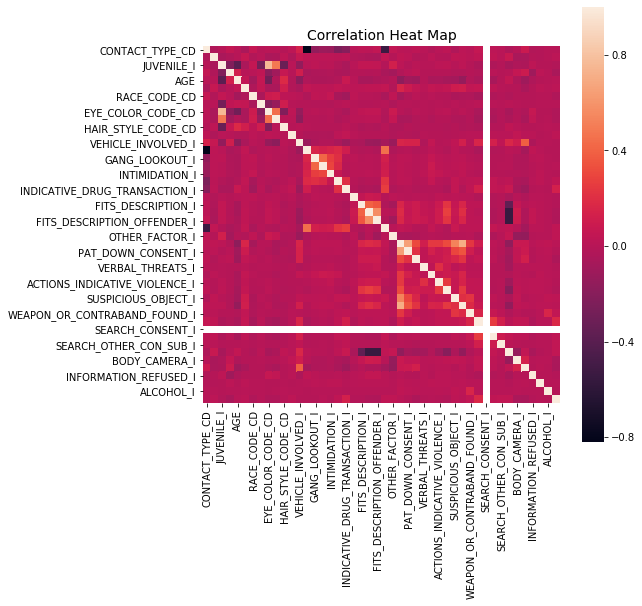

In [120]:
# correlation chart

corrmat = df_arrests.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

In [121]:
# saving this cleaned df to csv

df_model_clean = df_arrests
df_model_clean.to_csv('ISR_data_clean_TS.csv', index=False)

In [122]:
label_encoder_comp = LabelEncoder()
label_encoder_comp = label_encoder_comp.fit(y)
label_encoded_y = label_encoder_comp.transform(y)

In [123]:
df_arrests['COMPLEXION_CODE_CD'] = label_encoder_comp.fit_transform(df_arrests['COMPLEXION_CODE_CD'])

In [124]:
df_arrests.drop(columns = ["SEARCH_CONSENT_I", "ENFORCEMENT_TYPE_CD"], axis=0, inplace=True)

In [125]:
df_arrests.drop(columns = ["ENFORCEMENT_ACTION_TAKEN_I"], axis=0, inplace=True)

In [126]:
df_arrests= df_arrests.drop(['CREATED_DATE'], axis = 1)

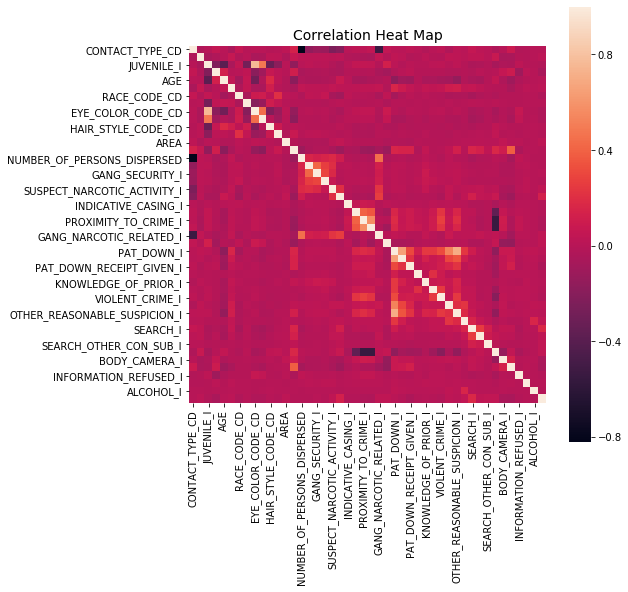

In [127]:
# correlation chart

corrmat = df_arrests.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

In [128]:
y = df_arrests['HIGHEST_100_OFFICERS']

In [129]:
y.value_counts()

0    279816
1      9115
Name: HIGHEST_100_OFFICERS, dtype: int64

In [130]:
# run this after pasting all of the column names in

df_arrests = pd.get_dummies(df_arrests, columns=['CONTACT_HOUR', 'AGE', 'SEX_CODE_CD', 'RACE_CODE_CD', 'BUILD_CODE_CD', 'EYE_COLOR_CODE_CD', 'HAIR_COLOR_CODE_CD', 'HAIR_STYLE_CODE_CD', 'COMPLEXION_CODE_CD', 'AREA', 'NUMBER_OF_PERSONS_DISPERSED'])
df_arrests.head()

,CONTACT_TYPE_CD,JUVENILE_I,NAME_VERIFIED_I,ZIP_CD,VEHICLE_INVOLVED_I,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,SEARCH_I,SEARCH_CANNABIS_I,SEARCH_OTHER_CON_SUB_I,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ALCOHOL_I,HIGHEST_100_OFFICERS,CONTACT_HOUR_0,CONTACT_HOUR_1,CONTACT_HOUR_2,CONTACT_HOUR_3,CONTACT_HOUR_4,CONTACT_HOUR_5,CONTACT_HOUR_6,CONTACT_HOUR_7,CONTACT_HOUR_8,CONTACT_HOUR_9,CONTACT_HOUR_10,CONTACT_HOUR_11,CONTACT_HOUR_12,CONTACT_HOUR_13,CONTACT_HOUR_14,CONTACT_HOUR_15,CONTACT_HOUR_16,CONTACT_HOUR_17,CONTACT_HOUR_18,CONTACT_HOUR_19,CONTACT_HOUR_20,CONTACT_HOUR_21,CONTACT_HOUR_22,CONTACT_HOUR_23,AGE_0.0,AGE_1.0,AGE_3.0,AGE_4.0,AGE_5.0,AGE_6.0,AGE_7.0,AGE_8.0,AGE_9.0,AGE_10.0,AGE_11.0,AGE_12.0,AGE_13.0,AGE_14.0,AGE_15.0,AGE_16.0,AGE_17.0,AGE_18.0,AGE_19.0,AGE_20.0,AGE_21.0,AGE_22.0,AGE_23.0,AGE_24.0,AGE_25.0,AGE_26.0,AGE_27.0,AGE_28.0,AGE_29.0,AGE_30.0,AGE_31.0,AGE_32.0,AGE_33.0,AGE_34.0,AGE_35.0,AGE_36.0,AGE_37.0,AGE_38.0,AGE_39.0,AGE_40.0,AGE_41.0,AGE_42.0,AGE_43.0,AGE_44.0,AGE_45.0,AGE_46.0,AGE_47.0,AGE_48.0,AGE_49.0,AGE_50.0,AGE_51.0,AGE_52.0,AGE_53.0,AGE_54.0,AGE_55.0,AGE_56.0,AGE_57.0,AGE_58.0,AGE_59.0,AGE_60.0,AGE_61.0,AGE_62.0,AGE_63.0,AGE_64.0,AGE_65.0,AGE_66.0,AGE_67.0,AGE_68.0,AGE_69.0,AGE_70.0,AGE_71.0,AGE_72.0,AGE_73.0,AGE_74.0,AGE_75.0,AGE_76.0,AGE_77.0,AGE_78.0,AGE_79.0,AGE_80.0,AGE_81.0,AGE_82.0,AGE_83.0,AGE_84.0,AGE_85.0,AGE_86.0,AGE_87.0,AGE_88.0,AGE_89.0,AGE_90.0,AGE_91.0,AGE_92.0,AGE_93.0,AGE_94.0,AGE_99.0,AGE_100.0,AGE_109.0,AGE_112.0,AGE_115.0,AGE_116.0,AGE_117.0,AGE_118.0,AGE_119.0,AGE_120.0,AGE_122.0,AGE_130.0,AGE_133.0,AGE_135.0,AGE_138.0,AGE_144.0,AGE_146.0,AGE_147.0,AGE_167.0,AGE_320.0,AGE_631.0,AGE_720.0,AGE_819.0,AGE_821.0,AGE_822.0,AGE_823.0,AGE_824.0,AGE_852.0,AGE_922.0,AGE_928.0,AGE_931.0,AGE_934.0,AGE_942.0,AGE_946.0,AGE_957.0,SEX_CODE_CD_0,SEX_CODE_CD_1,SEX_CODE_CD_2,RACE_CODE_CD_0,RACE_CODE_CD_1,RACE_CODE_CD_2,RACE_CODE_CD_3,RACE_CODE_CD_4,RACE_CODE_CD_5,RACE_CODE_CD_6,RACE_CODE_CD_7,RACE_CODE_CD_8,BUILD_CODE_CD_0,BUILD_CODE_CD_1,BUILD_CODE_CD_2,BUILD_CODE_CD_3,BUILD_CODE_CD_4,BUILD_CODE_CD_5,EYE_COLOR_CODE_CD_0,EYE_COLOR_CODE_CD_1,EYE_COLOR_CODE_CD_2,EYE_COLOR_CODE_CD_3,EYE_COLOR_CODE_CD_4,EYE_COLOR_CODE_CD_5,EYE_COLOR_CODE_CD_6,EYE_COLOR_CODE_CD_7,EYE_COLOR_CODE_CD_8,EYE_COLOR_CODE_CD_9,EYE_COLOR_CODE_CD_10,HAIR_COLOR_CODE_CD_0,HAIR_COLOR_CODE_CD_1,HAIR_COLOR_CODE_CD_2,HAIR_COLOR_CODE_CD_3,HAIR_COLOR_CODE_CD_4,HAIR_COLOR_CODE_CD_5,HAIR_COLOR_CODE_CD_6,HAIR_COLOR_CODE_CD_7,HAIR_COLOR_CODE_CD_8,HAIR_COLOR_CODE_CD_9,HAIR_COLOR_CODE_CD_10,HAIR_COLOR_CODE_CD_11,HAIR_COLOR_CODE_CD_12,HAIR_COLOR_CODE_CD_13,HAIR_COLOR_CODE_CD_14,HAIR_COLOR_CODE_CD_15,HAIR_STYLE_CODE_CD_0,HAIR_STYLE_CODE_CD_1,HAIR_STYLE_CODE_CD_2,HAIR_STYLE_CODE_CD_3,HAIR_STYLE_CODE_CD_4,HAIR_STYLE_CODE_CD_5,HAIR_STYLE_CODE_CD_6,HAIR_STYLE_CODE_CD_7,HAIR_STYLE_CODE_CD_8,HAIR_STYLE_CODE_CD_9,HAIR_STYLE_CODE_CD_10,HAIR_STYLE_CODE_CD_11,HAIR_STYLE_CODE_CD_12,HAIR_STYLE_CODE_CD_13,HAIR_STYLE_CODE_CD_14,HAIR_STYLE_CODE_CD_15,HAIR_STYLE_CODE_CD_16,HAIR_STYLE_CODE_CD_17,HAIR_STYLE_CODE_CD_18,HAIR_STYLE_CODE_CD_19,HAIR_STYLE_CODE_CD_20,HAIR_STYLE_CODE_CD_21,HAIR_STYLE_CODE_CD_22,HAIR_STYLE_CODE_CD_23,HAIR_STYLE_CODE_CD_24,HAIR_STYLE_CODE_CD_25,HAIR_STYLE_CODE_CD_26,HAIR_STYLE_CODE_CD_27,HAIR_STYLE_CODE_CD_28,HAIR_STYLE_CODE_CD_29,HAIR_STYLE_CODE_CD_30,COMPLEXION_CODE_CD_0,COMPLEXION_CODE_CD_1,COMPLEXION_CODE_CD_2,COMPLEXION_CODE_CD_3,COMPLEXION_CODE_CD_4,COMPLEXION_CODE_CD_5,COMPLEXION_CODE_CD_6,COMPLEXION_CODE_CD_7,COMPLEXION_CODE_CD_8,COMPLEXION_CODE_CD_9,COMPLEXION_CODE_CD_10,COMPLEXION_CODE_C

In [131]:
df_arrests = pd.get_dummies(df_arrests, columns=['ZIP_CD'])
df_arrests.head()

,CONTACT_TYPE_CD,JUVENILE_I,NAME_VERIFIED_I,VEHICLE_INVOLVED_I,GANG_LOOKOUT_I,GANG_SECURITY_I,INTIMIDATION_I,SUSPECT_NARCOTIC_ACTIVITY_I,INDICATIVE_DRUG_TRANSACTION_I,INDICATIVE_CASING_I,FITS_DESCRIPTION_I,PROXIMITY_TO_CRIME_I,FITS_DESCRIPTION_OFFENDER_I,GANG_NARCOTIC_RELATED_I,OTHER_FACTOR_I,PAT_DOWN_I,PAT_DOWN_CONSENT_I,PAT_DOWN_RECEIPT_GIVEN_I,VERBAL_THREATS_I,KNOWLEDGE_OF_PRIOR_I,ACTIONS_INDICATIVE_VIOLENCE_I,VIOLENT_CRIME_I,SUSPICIOUS_OBJECT_I,OTHER_REASONABLE_SUSPICION_I,WEAPON_OR_CONTRABAND_FOUND_I,SEARCH_I,SEARCH_CANNABIS_I,SEARCH_OTHER_CON_SUB_I,EVENT_ASSIGNEED_BY_CD,BODY_CAMERA_I,CAR_CAMERA_I,INFORMATION_REFUSED_I,GANG_OTHER_I,ALCOHOL_I,HIGHEST_100_OFFICERS,CONTACT_HOUR_0,CONTACT_HOUR_1,CONTACT_HOUR_2,CONTACT_HOUR_3,CONTACT_HOUR_4,CONTACT_HOUR_5,CONTACT_HOUR_6,CONTACT_HOUR_7,CONTACT_HOUR_8,CONTACT_HOUR_9,CONTACT_HOUR_10,CONTACT_HOUR_11,CONTACT_HOUR_12,CONTACT_HOUR_13,CONTACT_HOUR_14,CONTACT_HOUR_15,CONTACT_HOUR_16,CONTACT_HOUR_17,CONTACT_HOUR_18,CONTACT_HOUR_19,CONTACT_HOUR_20,CONTACT_HOUR_21,CONTACT_HOUR_22,CONTACT_HOUR_23,AGE_0.0,AGE_1.0,AGE_3.0,AGE_4.0,AGE_5.0,AGE_6.0,AGE_7.0,AGE_8.0,AGE_9.0,AGE_10.0,AGE_11.0,AGE_12.0,AGE_13.0,AGE_14.0,AGE_15.0,AGE_16.0,AGE_17.0,AGE_18.0,AGE_19.0,AGE_20.0,AGE_21.0,AGE_22.0,AGE_23.0,AGE_24.0,AGE_25.0,AGE_26.0,AGE_27.0,AGE_28.0,AGE_29.0,AGE_30.0,AGE_31.0,AGE_32.0,AGE_33.0,AGE_34.0,AGE_35.0,AGE_36.0,AGE_37.0,AGE_38.0,AGE_39.0,AGE_40.0,AGE_41.0,AGE_42.0,AGE_43.0,AGE_44.0,AGE_45.0,AGE_46.0,AGE_47.0,AGE_48.0,AGE_49.0,AGE_50.0,AGE_51.0,AGE_52.0,AGE_53.0,AGE_54.0,AGE_55.0,AGE_56.0,AGE_57.0,AGE_58.0,AGE_59.0,AGE_60.0,AGE_61.0,AGE_62.0,AGE_63.0,AGE_64.0,AGE_65.0,AGE_66.0,AGE_67.0,AGE_68.0,AGE_69.0,AGE_70.0,AGE_71.0,AGE_72.0,AGE_73.0,AGE_74.0,AGE_75.0,AGE_76.0,AGE_77.0,AGE_78.0,AGE_79.0,AGE_80.0,AGE_81.0,AGE_82.0,AGE_83.0,AGE_84.0,AGE_85.0,AGE_86.0,AGE_87.0,AGE_88.0,AGE_89.0,AGE_90.0,AGE_91.0,AGE_92.0,AGE_93.0,AGE_94.0,AGE_99.0,AGE_100.0,AGE_109.0,AGE_112.0,AGE_115.0,AGE_116.0,AGE_117.0,AGE_118.0,AGE_119.0,AGE_120.0,AGE_122.0,AGE_130.0,AGE_133.0,AGE_135.0,AGE_138.0,AGE_144.0,AGE_146.0,AGE_147.0,AGE_167.0,AGE_320.0,AGE_631.0,AGE_720.0,AGE_819.0,AGE_821.0,AGE_822.0,AGE_823.0,AGE_824.0,AGE_852.0,AGE_922.0,AGE_928.0,AGE_931.0,AGE_934.0,AGE_942.0,AGE_946.0,AGE_957.0,SEX_CODE_CD_0,SEX_CODE_CD_1,SEX_CODE_CD_2,RACE_CODE_CD_0,RACE_CODE_CD_1,RACE_CODE_CD_2,RACE_CODE_CD_3,RACE_CODE_CD_4,RACE_CODE_CD_5,RACE_CODE_CD_6,RACE_CODE_CD_7,RACE_CODE_CD_8,BUILD_CODE_CD_0,BUILD_CODE_CD_1,BUILD_CODE_CD_2,BUILD_CODE_CD_3,BUILD_CODE_CD_4,BUILD_CODE_CD_5,EYE_COLOR_CODE_CD_0,EYE_COLOR_CODE_CD_1,EYE_COLOR_CODE_CD_2,EYE_COLOR_CODE_CD_3,EYE_COLOR_CODE_CD_4,EYE_COLOR_CODE_CD_5,EYE_COLOR_CODE_CD_6,EYE_COLOR_CODE_CD_7,EYE_COLOR_CODE_CD_8,EYE_COLOR_CODE_CD_9,EYE_COLOR_CODE_CD_10,HAIR_COLOR_CODE_CD_0,HAIR_COLOR_CODE_CD_1,HAIR_COLOR_CODE_CD_2,HAIR_COLOR_CODE_CD_3,HAIR_COLOR_CODE_CD_4,HAIR_COLOR_CODE_CD_5,HAIR_COLOR_CODE_CD_6,HAIR_COLOR_CODE_CD_7,HAIR_COLOR_CODE_CD_8,HAIR_COLOR_CODE_CD_9,HAIR_COLOR_CODE_CD_10,HAIR_COLOR_CODE_CD_11,HAIR_COLOR_CODE_CD_12,HAIR_COLOR_CODE_CD_13,HAIR_COLOR_CODE_CD_14,HAIR_COLOR_CODE_CD_15,HAIR_STYLE_CODE_CD_0,HAIR_STYLE_CODE_CD_1,HAIR_STYLE_CODE_CD_2,HAIR_STYLE_CODE_CD_3,HAIR_STYLE_CODE_CD_4,HAIR_STYLE_CODE_CD_5,HAIR_STYLE_CODE_CD_6,HAIR_STYLE_CODE_CD_7,HAIR_STYLE_CODE_CD_8,HAIR_STYLE_CODE_CD_9,HAIR_STYLE_CODE_CD_10,HAIR_STYLE_CODE_CD_11,HAIR_STYLE_CODE_CD_12,HAIR_STYLE_CODE_CD_13,HAIR_STYLE_CODE_CD_14,HAIR_STYLE_CODE_CD_15,HAIR_STYLE_CODE_CD_16,HAIR_STYLE_CODE_CD_17,HAIR_STYLE_CODE_CD_18,HAIR_STYLE_CODE_CD_19,HAIR_STYLE_CODE_CD_20,HAIR_STYLE_CODE_CD_21,HAIR_STYLE_CODE_CD_22,HAIR_STYLE_CODE_CD_23,HAIR_STYLE_CODE_CD_24,HAIR_STYLE_CODE_CD_25,HAIR_STYLE_CODE_CD_26,HAIR_STYLE_CODE_CD_27,HAIR_STYLE_CODE_CD_28,HAIR_STYLE_CODE_CD_29,HAIR_STYLE_CODE_CD_30,COMPLEXION_CODE_CD_0,COMPLEXION_CODE_CD_1,COMPLEXION_CODE_CD_2,COMPLEXION_CODE_CD_3,COMPLEXION_CODE_CD_4,COMPLEXION_CODE_CD_5,COMPLEXION_CODE_CD_6,COMPLEXION_CODE_CD_7,COMPLEXION_CODE_CD_8,COMPLEXION_CODE_CD_9,COMPLEXION_CODE_CD_10,COMPLEXION_CODE_CD_11,CO

In [132]:
df_arrests = df_arrests.drop(['HIGHEST_100_OFFICERS'], axis = 1)

In [133]:
df_arrests = df_arrests.drop(['ZIP_CD_``'], axis = 1)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(df_arrests, y, test_size = 0.25, random_state = 0, stratify=y)

In [135]:
X = df_arrests.as_matrix().astype(np.float)
X

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [136]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.19244076, -0.36662064, -0.79443971, ..., -0.00526204,
        -0.06570511, -0.0166421 ],
       [ 0.19244076, -0.36662064, -0.79443971, ..., -0.00526204,
        -0.06570511, -0.0166421 ],
       [ 0.19244076, -0.36662064, -0.79443971, ..., -0.00526204,
        -0.06570511, -0.0166421 ],
       ...,
       [ 0.19244076, -0.36662064, -0.79443971, ..., -0.00526204,
        -0.06570511, -0.0166421 ],
       [ 0.19244076, -0.36662064,  1.25874877, ..., -0.00526204,
        -0.06570511, -0.0166421 ],
       [ 0.19244076, -0.36662064, -0.79443971, ..., -0.00526204,
        -0.06570511, -0.0166421 ]])

In [137]:
clf = LogisticRegression(C=1.0, max_iter=1000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)


print(f'Logistic Regression Testing Accuracy: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Logistic Regression Testing Accuracy: 0.9679786247283098
AUC: 0.5199204402898349
Precision: 0.42410714285714285
Recall: 0.04168494953927161
F1 Score: 0.0759089093088294


In [138]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    """This function takes in a confusion matrix (cm) and normalizes the values if normalize is set to True. 
    If so, normalize the raw confusion matrix before visualizing.
    If false, raw confusion matrix is visualized."""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    #plt.title('Confusion Matrix') 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    class_names = set(y) # Get class labels to add to matrix
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

In [139]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[69825   129]
 [ 2184    95]]


Normalized confusion matrix
[[0.99815593 0.00184407]
 [0.95831505 0.04168495]]


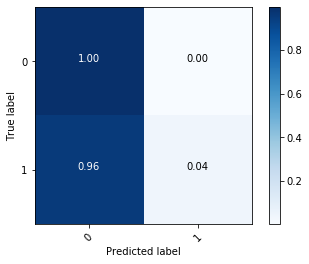

In [140]:
# Plot a normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True)

In [141]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
preds = gbc.predict(X_test)

print(f'Gradient Boosting: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Gradient Boosting: 0.969169216286185
AUC: 0.5426088093268788
Precision: 0.5751445086705202
Recall: 0.08731899956121106
F1 Score: 0.15161904761904763


In [142]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[69807   147]
 [ 2080   199]]


Normalized confusion matrix
[[0.99789862 0.00210138]
 [0.912681   0.087319  ]]


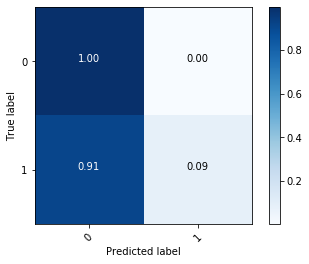

In [143]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True)

In [144]:
xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print(f'XGB Classifier: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

XGB Classifier: 0.9714396466988773
AUC: 0.583046687873607
Precision: 0.6956521739130435
Recall: 0.16849495392716105
F1 Score: 0.27128223242670435


In [145]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[69786   168]
 [ 1895   384]]


Normalized confusion matrix
[[0.99759842 0.00240158]
 [0.83150505 0.16849495]]


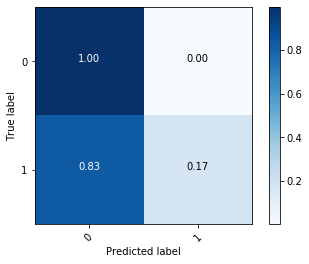

In [146]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [147]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
preds = dt.predict(X_test)


print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Decision Tree: 0.9590353439563635
AUC: 0.6575085548287903
Precision: 0.34615384615384615
Recall: 0.3356735410267661
F1 Score: 0.340833147694364


In [148]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[68509  1445]
 [ 1514   765]]


Normalized confusion matrix
[[0.97934357 0.02065643]
 [0.66432646 0.33567354]]


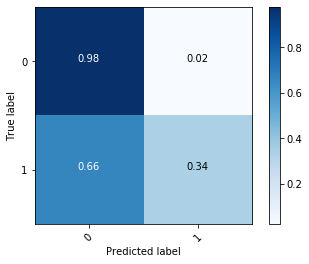

In [149]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [150]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)

print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Decision Tree: 0.9709827917987623
AUC: 0.5567044477783388
Precision: 0.7699115044247787
Recall: 0.11452391399736726
F1 Score: 0.19938884644766997


In [151]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[69876    78]
 [ 2018   261]]


Normalized confusion matrix
[[0.99888498 0.00111502]
 [0.88547609 0.11452391]]


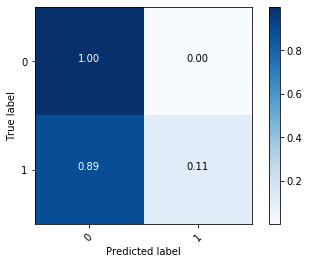

In [152]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [153]:
# best performing model is decision tree
# let's see if we can improve the results (34% F1 score) by tweaking the parameters

In [154]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed: 42.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,


In [155]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=83,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [156]:
dt2 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=83,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
dt2.fit(X_train, y_train)
preds = dt2.predict(X_test)


print(f'Decision Tree 2: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Decision Tree 2: 0.9695706948347708
AUC: 0.551942705833532
Precision: 0.6004962779156328
Recall: 0.10618692408951294
F1 Score: 0.18046234153616703


In [157]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[69793   161]
 [ 2037   242]]


Normalized confusion matrix
[[0.99769849 0.00230151]
 [0.89381308 0.10618692]]


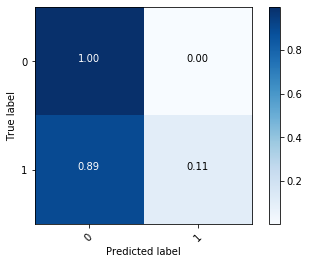

In [158]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
# add in adaboost, neural network

In [159]:
# not any better! we'll stick with the original decision tree model

In [160]:
# testing for imbalance

Text(0, 0.5, 'True positive rate')

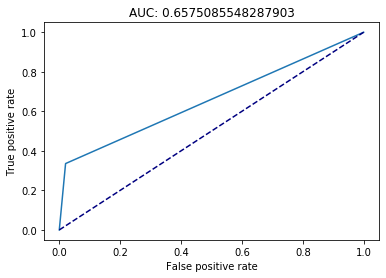

In [161]:
preds = dt.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label=1)

auc = roc_auc_score(y_test, preds)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
plt.title(f'AUC: {auc}')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

In [166]:
# define grid
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=dt, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.690063 using {'class_weight': {0: 1, 1: 10}}
0.638556 (0.008300) with: {'class_weight': {0: 100, 1: 1}}
0.637471 (0.006816) with: {'class_weight': {0: 10, 1: 1}}
0.662373 (0.007103) with: {'class_weight': {0: 1, 1: 1}}
0.690063 (0.008772) with: {'class_weight': {0: 1, 1: 10}}
0.667556 (0.008654) with: {'class_weight': {0: 1, 1: 100}}


In [167]:
dt3 = DecisionTreeClassifier(class_weight='balanced')
dt3.fit(X_train, y_train)
preds = dt3.predict(X_test)


print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Decision Tree: 0.9526393753547547
AUC: 0.6605737923459336
Precision: 0.29099560761347
Recall: 0.3488372093023256
F1 Score: 0.31730193574136895


In [168]:
dt4 = DecisionTreeClassifier(criterion='gini', class_weight='balanced')
dt4.fit(X_train, y_train)
preds = dt4.predict(X_test)


print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Decision Tree: 0.9523901817728739
AUC: 0.6602328894548556
Precision: 0.2889374090247453
Recall: 0.34839842035980695
F1 Score: 0.3158941714740402


In [170]:
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)
preds = ab.predict(X_test)


print(f'Decision Tree 2: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Decision Tree 2: 0.9664557750612601
AUC: 0.5286853206099218
Precision: 0.330188679245283
Recall: 0.06143045195261079
F1 Score: 0.10358860525342212


In [171]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[69670   284]
 [ 2139   140]]


Normalized confusion matrix
[[0.99594019 0.00405981]
 [0.93856955 0.06143045]]


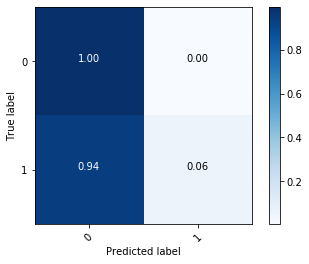

In [172]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [177]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
preds = sgd.predict(X_test)


print(f'SGD Classifier: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

SGD Classifier: 0.968449323716307
AUC: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [178]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[69954     0]
 [ 2279     0]]


Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


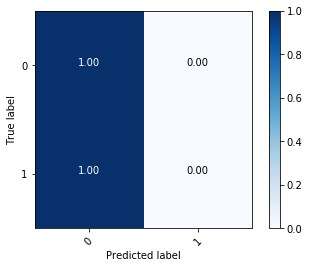

In [179]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [181]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)
preds = svc.predict(X_test)


print(f'Support Vector Classification: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

SGD Classifier: 0.9685877645951296
AUC: 0.5021939447125933
Precision: 1.0
Recall: 0.004387889425186486
F1 Score: 0.00873743993010048


In [182]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[69954     0]
 [ 2269    10]]


Normalized confusion matrix
[[1.         0.        ]
 [0.99561211 0.00438789]]


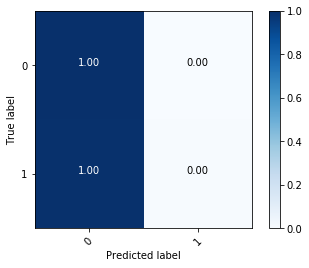

In [183]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
# original decision tree is still the best performing!

In [ ]:
# from sklearn.tree import export_graphviz
# import graphviz

# export_graphviz(dt, out_file="mytree.dot")
# with open("mytree.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

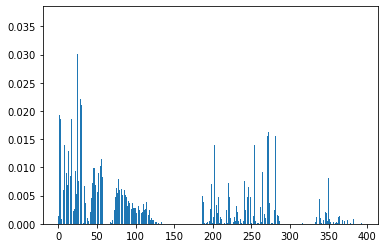

In [173]:
# get importance
importance = dt.feature_importances_
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [174]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(dt, X_train, y_train):
    return r2_score(y_train, dt.predict(X_train))

perm_imp_rfpimp = permutation_importances(dt, X_train, y_train, r2)
perm_imp_rfpimp.head(10)

/Users/mac/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


,Importance
Feature,
SEARCH_I,1.005988
ZIP_CD_60623,0.510733
BODY_CAMERA_I,0.371442
INDICATIVE_DRUG_TRANSACTION_I,0.278581
SUSPICIOUS_OBJECT_I,0.221833
AREA_3,0.216674
ZIP_CD_60624,0.139291
CONTACT_HOUR_19,0.118655
OTHER_REASONABLE_SUSPICION_I,0.113496


In [ ]:
# resampling - why we're choosing not to use

In [ ]:
# EDA for top few features

In [ ]:
df_clean.groupby(["CONTACT_HOUR","ENFORCEMENT_TYPE_CD"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=12)